In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import string
import nltk
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import spacy
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import seaborn as sns
from sklearn.decomposition import PCA


C:\Users\WMosleh\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\WMosleh\Anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\WMosleh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\WMosleh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
base_url = 'https://www.airlinequality.com/airline-reviews/british-airways'
pages = 10
page_size=100
reviews = []
recommendation = []
seat_comfort=[]
for i in range(1, pages+1):
    
    print(f'Scrapping page {i}')
    # Create URL to collect links from paginated data
    url = f'{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}'
    
    # Collect HTML data from this page
    response = requests.get(url)
        #parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    
    for para in parsed_content.find_all("div",{"class":"text_content"}):
        reviews.append(para.get_text())
        
    for para in parsed_content.find_all("td", {"class": lambda x: x and x.startswith("review-value rating-")}):
        recommendation.append(para.get_text())
    
    
   
    
    print(f"   ---> {len(reviews)} total reviews")

Scrapping page 1
   ---> 100 total reviews
Scrapping page 2
   ---> 200 total reviews
Scrapping page 3
   ---> 300 total reviews
Scrapping page 4
   ---> 400 total reviews
Scrapping page 5
   ---> 500 total reviews
Scrapping page 6
   ---> 600 total reviews
Scrapping page 7
   ---> 700 total reviews
Scrapping page 8
   ---> 800 total reviews
Scrapping page 9
   ---> 900 total reviews
Scrapping page 10
   ---> 1000 total reviews


In [4]:
df = pd.DataFrame()
df['reviews'] = reviews
df['recommendation'] = recommendation

In [5]:
df.to_csv("C:/Users/WMosleh/Documents/Data Science Job Simulation - British Airways/BA_reviews.csv")

In [6]:
df = pd.read_csv("C:/Users/WMosleh/Documents/Data Science Job Simulation - British Airways/BA_reviews.csv")

In [7]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [8]:
df

,reviews,recommendation
0,✅ Trip Verified | Every single aspect of my ...,no
1,✅ Trip Verified | I have not used BA for 15 y...,no
2,✅ Trip Verified | ​British Airways website wou...,no
3,Not Verified | There was a time when British ...,yes
4,✅ Trip Verified | My flight was cancelled a...,no
...,...,...
995,Not Verified | London to Sydney via Singapore....,yes
996,✅ Trip Verified | Lisbon to London. I pay ext...,no
997,Not Verified | BA operate daily shuttles from...,no
998,✅ Trip Verified | Doha to London. Surprisingl...,yes


In [9]:
df['reviews'] = df['reviews'].str.split('|').str.get(1).str.strip()

In [10]:
df['reviews'] = df['reviews'].apply(lambda x: str(x))

In [11]:
df['reviews'][0]

'Every single aspect of my recent journey from Gatwick to Las Palmas had major flaws. I tried to check in at the Club check in and was turned back at the entrance to the Club check in as there were "luggage issues". Nowhere to go or sit, so I had to stand in the departures hall for 45 minutes which was very chilly and I was not dressed for the cold. Eventually checked in andwent through to the BA lounge which was really full and struggled to find two seats together. Then went down to board the plane and no priority boarding so had to join a long queue to access the plane. On the plane it became obvious pretty quickly that all the supplying for food and alcohol had gone badly wrong. The food item I wanted for my main course was finishied so i asked for a cheese board and some red primitivo wine. Then found out no Primitivo wine left. Nobody in rows 11 or 12 got their wine with their lunch  and by 14.23 (two hours into a four plus hour flight) the plane was out of "still" wine completely

In [12]:

# Load spacy
nlp = spacy.load('en_core_web_sm')

def process_text(text, stem='Lem'):
    
    # convert all to lowerre.sub(r'\n', '', text)
    text = text.lower()
    
    # remove line breaks
    text = re.sub(r'\n', '', text)
    
    # remove punctuations
    translator = str.maketrans('', '', string.punctuation) 
    text = text.translate(translator)
    
    # Remove numbers
    text = re.sub(r'\w*\d\w*', '', text)
    # Tokenize each text in the list
    doc = nlp(text)
    tokenized_list = [token.lemma_ for token in doc]
    
    # Remove stop words
    useless_words = nltk.corpus.stopwords.words("english")
    useless_words = useless_words + ['hi', 'im']

    text_filtered = [word for word in tokenized_list if word not in useless_words]
    
    # Stem or Lemmatize
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    elif stem == 'Spacy':
        text_filtered = nlp(' '.join(text_filtered))
        text_stemmed = [y.lemma_ for y in text_filtered]
    else:
        text_stemmed = text_filtered
    
    # Remove any empty strings that may have resulted from processing
    text_stemmed = [word for word in text_stemmed if word.strip() != '']
    
#     return ' '.join(text_stemmed)
    return text_stemmed

   

In [13]:
# Apply the function to each row and create a new column
df['processed_reviews'] = df['reviews'].apply(process_text)

In [14]:
df

,reviews,recommendation,processed_reviews
0,Every single aspect of my recent journey from ...,no,"[every, single, aspect, recent, journey, gatwi..."
1,I have not used BA for 15 years and the experi...,no,"[I, use, ba, year, experience, abysmal, plane,..."
2,​British Airways website wouldn't let me add a...,no,"[​british, airway, website, would, let, I, add..."
3,There was a time when British Airways was the ...,yes,"[time, british, airway, pinnacle, air, travel,..."
4,My flight was cancelled and no support was pro...,no,"[flight, cancel, support, provide, try, call, ..."
...,...,...,...
995,London to Sydney via Singapore. I would like t...,yes,"[london, sydney, via, singapore, I, would, lik..."
996,"Lisbon to London. I pay extra to check my bag,...",no,"[lisbon, london, I, pay, extra, check, bag, en..."
997,BA operate daily shuttles from London to Glasg...,no,"[ba, operate, daily, shuttle, london, glasgow,..."
998,"Doha to London. Surprisingly good flight, onti...",yes,"[doha, london, surprisingly, good, flight, ont..."


### Convert words to vectors: Vectorization

## Bag of Words

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

# Convert tokenized lists back to text
text_data = df['processed_reviews'].apply(lambda tokens: ' '.join(tokens))

# Initialize the CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the documents
X_bow = vectorizer.fit_transform(text_data)

# Convert sparse matrix to array
X_bow_array = X_bow.toarray()

# Get the feature names (vocabulary)
vocab_bow = vectorizer.get_feature_names_out()

# Display feature names
print("Vocabulary (BoW):", vocab_bow)
print("BoW Representation:\n", X_bow_array)
# Convert the BoW representation to a DataFrame
bow_df = pd.DataFrame(X_bow.toarray(), columns=vectorizer.get_feature_names_out())
bow_df
# Compute word frequencies
word_frequencies = bow_df.sum().sort_values(ascending=False)
word_frequencies
# # Display the word frequencies
# print("Word Frequencies:")
# print(word_frequencies)

Vocabulary (BoW): ['aa' 'abandon' 'abbreviate' ... 'zurich' 'zusammenschluss' 'über']
BoW Representation:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


flight        2263
ba            1369
seat           886
service        756
get            673
              ... 
facilitate       1
profound         1
facial           1
facebook         1
über             1
Length: 5831, dtype: int64

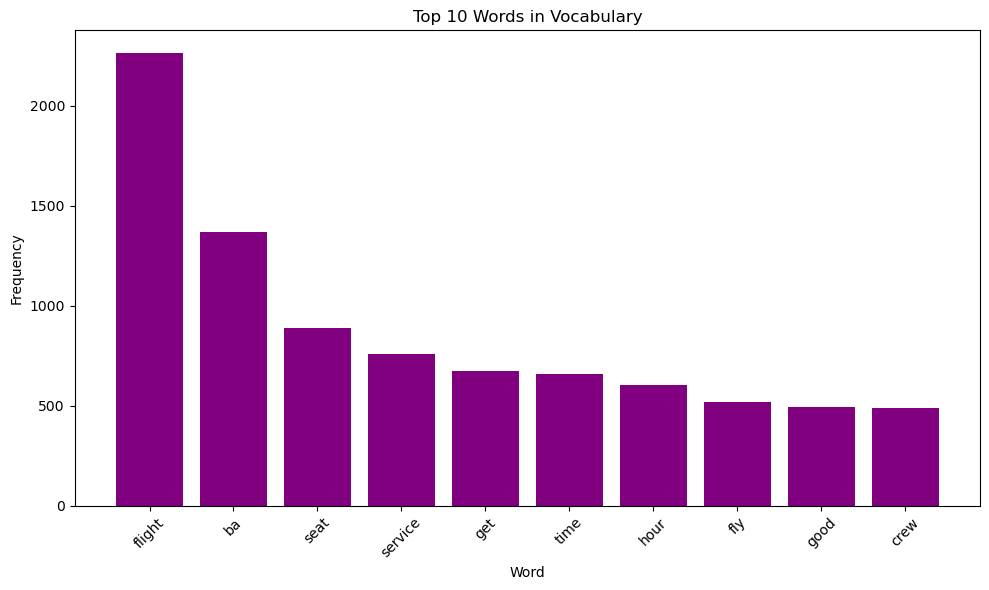

In [16]:
bow_freq = pd.DataFrame(list(word_frequencies.items()), columns=['word','Frequency'])
bow_freq
# Set the number of top words you want to visualize
top_n = 10

# Select the top N words
top_words = bow_freq.iloc[:top_n]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_words['word'], top_words['Frequency'], color='purple')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title(f'Top {top_n} Words in Vocabulary')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
len(X_bow_array[0])

5831

In [20]:
bow_df.shape

(1000, 5831)

In [22]:
import numpy as np
pca = PCA(n_components=3)

# Fit PCA to the BoW representation
X_pca = pca.fit_transform(X_bow_array)

# Get the components and explained variance
components = pca.components_
explained_variance = pca.explained_variance_ratio_

# Get the feature names
vocab_bow = vectorizer.get_feature_names_out()

# Create a DataFrame for better visualization
components_df = pd.DataFrame(components, columns=vocab_bow)
components_df = components_df.transpose()
components_df.columns = [f'PC{i+1}' for i in range(components_df.shape[1])]

# Add explained variance as a row
components_df.loc['explained_variance'] = explained_variance

# Display the DataFrame
print("Principal Components and their contributions:")
print(components_df)

# To get the top contributing features for each principal component
top_contributors = 10  # You can change this number as needed
for i in range(len(components)):
    sorted_indices = np.argsort(np.abs(components[i]))[::-1]
    top_features = [vocab_bow[j] for j in sorted_indices[:top_contributors]]
    print(f"Top {top_contributors} features for PC{i+1}:")
    print(top_features)

Principal Components and their contributions:
                         PC1       PC2       PC3
aa                  0.002678  0.002323  0.002393
abandon             0.003189  0.000345  0.003120
abbreviate          0.000645  0.002602 -0.000789
abc                -0.000155 -0.000179 -0.000310
abdication          0.000013 -0.000418  0.000723
...                      ...       ...       ...
zum                 0.000025 -0.000509 -0.000503
zurich              0.012191 -0.004765 -0.014736
zusammenschluss     0.000025 -0.000509 -0.000503
über                0.000025 -0.000509 -0.000503
explained_variance  0.090673  0.040158  0.024782

[5832 rows x 3 columns]
Top 10 features for PC1:
['flight', 'ba', 'get', 'hour', 'would', 'tell', 'go', 'book', 'could', 'day']
Top 10 features for PC2:
['seat', 'ba', 'class', 'business', 'flight', 'good', 'cabin', 'crew', 'food', 'passenger']
Top 10 features for PC3:
['flight', 'british', 'seat', 'airway', 'good', 'customer', 'call', 'would', 'tell', 'crew']


In [23]:
components_df['PC2'].sort_values(ascending=False)

seat        0.474181
ba          0.316033
class       0.264100
business    0.243528
good        0.204903
              ...   
tell       -0.067220
day        -0.086737
call       -0.098088
cancel     -0.120577
flight     -0.238458
Name: PC2, Length: 5832, dtype: float64

In [24]:
pca.explained_variance_ratio_

array([0.090673  , 0.04015831, 0.02478217])

In [25]:
pca.components_

array([[ 2.67770356e-03,  3.18947576e-03,  6.45125767e-04, ...,
         1.21912232e-02,  2.49724906e-05,  2.49724906e-05],
       [ 2.32292359e-03,  3.44667589e-04,  2.60165680e-03, ...,
        -4.76501715e-03, -5.08735822e-04, -5.08735822e-04],
       [ 2.39334466e-03,  3.12030301e-03, -7.88801001e-04, ...,
        -1.47357878e-02, -5.03039812e-04, -5.03039812e-04]])

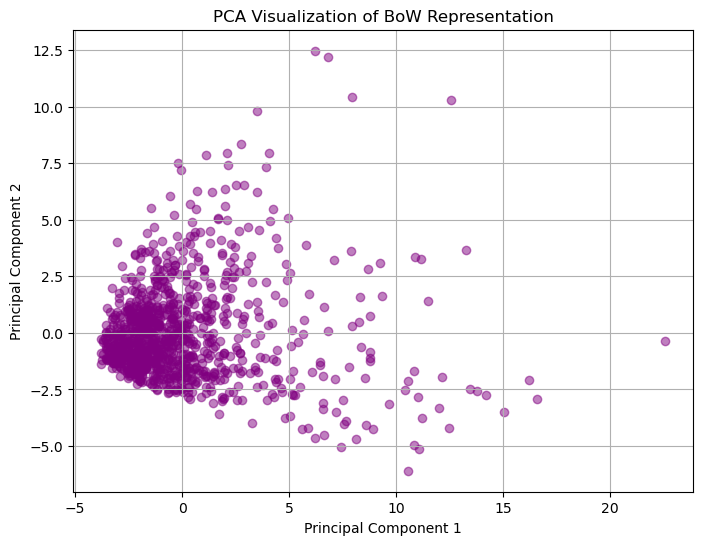

In [26]:
# Initialize PCA with desired number of components
pca = PCA(n_components=3)

# Fit PCA to the BoW representation
X_pca = pca.fit_transform(X_bow_array)

# Plot PCA results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, color='purple')
plt.title('PCA Visualization of BoW Representation')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

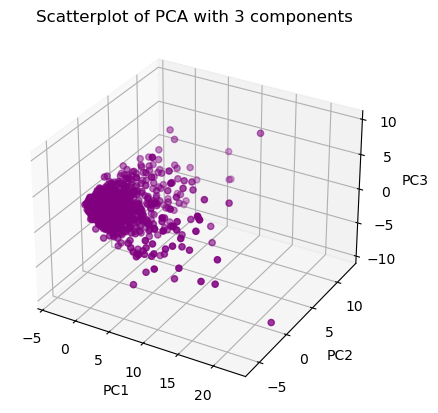

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract the three components
x = X_pca[:, 0]
y = X_pca[:, 1]
z = X_pca[:, 2]

# Plot the scatter plot
ax.scatter(x, y, z, c='purple', marker='o')

# Add labels and title
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Scatterplot of PCA with 3 components')

# Show the plot
plt.show()

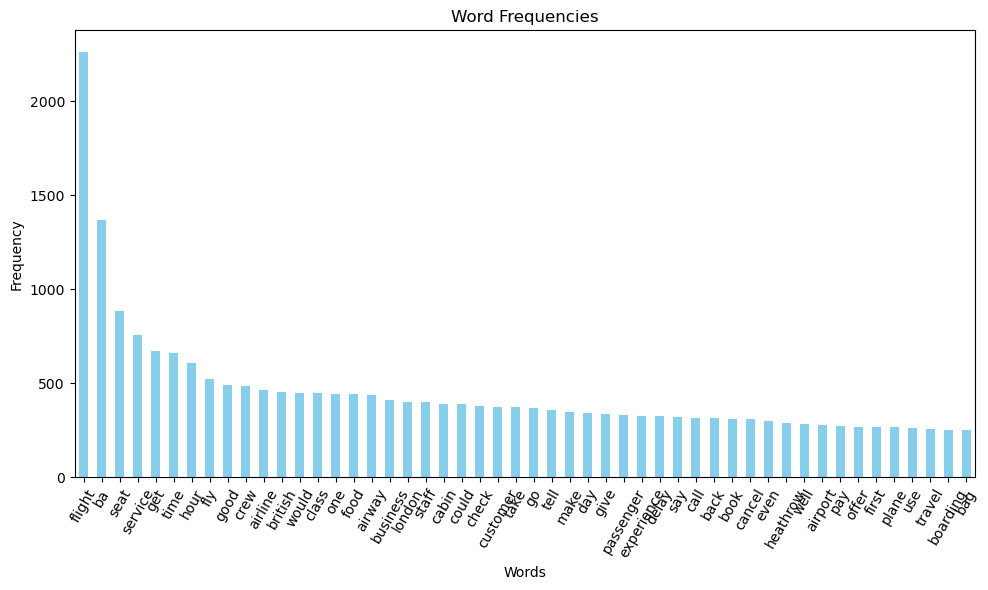

In [28]:
# Plot word frequencies of the first top "most frequent" 50 words
plt.figure(figsize=(10, 6))
word_frequencies[:50].plot(kind='bar', color='skyblue')
plt.title('Word Frequencies')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

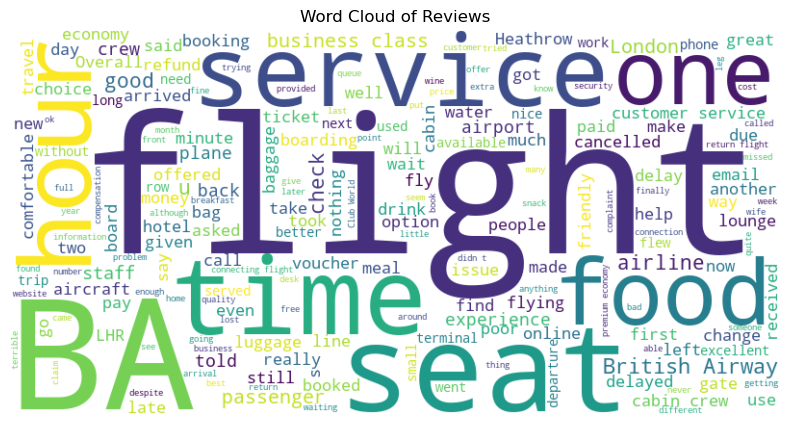

In [31]:
# Generate a word cloud from the reviews
text = " ".join(review for review in df['reviews'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Reviews')
plt.show()

In [32]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\WMosleh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\WMosleh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\WMosleh\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [33]:
dictionary = corpora.Dictionary(df['processed_reviews']) # maps each unique word to a unique integer ID
corpus = [dictionary.doc2bow(text) for text in df['processed_reviews']] #Bag-of-Words Format: Each review is converted into a list of tuples, where each tuple contains a word ID and its frequency in the document.


In [34]:
print(dictionary.token2id)

{'I': 0, 'access': 1, 'actually': 2, 'age': 3, 'alcohol': 4, 'almost': 5, 'already': 6, 'amount': 7, 'andwent': 8, 'announce': 9, 'anything': 10, 'apologetic': 11, 'apparently': 12, 'april': 13, 'arrive': 14, 'ask': 15, 'aspect': 16, 'available': 17, 'avio': 18, 'ba': 19, 'back': 20, 'bad': 21, 'badly': 22, 'become': 23, 'belt': 24, 'board': 25, 'boarding': 26, 'book': 27, 'bother': 28, 'card': 29, 'charge': 30, 'check': 31, 'cheese': 32, 'chilly': 33, 'clearly': 34, 'club': 35, 'cold': 36, 'communication': 37, 'company': 38, 'compensation': 39, 'complaint': 40, 'completely': 41, 'consider': 42, 'contact': 43, 'conveyor': 44, 'could': 45, 'course': 46, 'credit': 47, 'crew': 48, 'csd': 49, 'definitely': 50, 'delivery': 51, 'departure': 52, 'dress': 53, 'early': 54, 'easyjet': 55, 'economy': 56, 'enough': 57, 'entrance': 58, 'escalate': 59, 'eventually': 60, 'every': 61, 'exactly': 62, 'executive': 63, 'experience': 64, 'fact': 65, 'final': 66, 'find': 67, 'finishie': 68, 'first': 69, 'f

In [35]:
# Train LDA model
lda_model = gensim.models.LdaModel(corpus, num_topics=3, id2word=dictionary, passes=15)

In [36]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.020*"flight" + 0.016*"seat" + 0.015*"ba" + 0.013*"good" + 0.013*"I" + 0.013*"crew" + 0.011*"food" + 0.011*"service" + 0.010*"cabin" + 0.010*"class"
Topic: 1 
Words: 0.034*"I" + 0.015*"british" + 0.014*"airway" + 0.013*"flight" + 0.011*"customer" + 0.011*"service" + 0.010*"ba" + 0.007*"ticket" + 0.007*"call" + 0.006*"travel"
Topic: 2 
Words: 0.074*"I" + 0.033*"flight" + 0.017*"ba" + 0.011*"get" + 0.010*"hour" + 0.008*"seat" + 0.008*"would" + 0.007*"airline" + 0.007*"fly" + 0.007*"time"


In [37]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)
#pyLDAvis.save_html(vis, 'C:/Users/WMosleh/Documents/Data Science Job Simulation - British Airways/lda_vis.html')

# Each circle represents a topic
# The size of the circle represents prevalence of the topic in the corpus
# the distance between the circle represents the similarity between topics

## Sentiment Analysis

In [38]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\WMosleh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [39]:
# Initialize the VADER sentiment analyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [40]:
sid = SentimentIntensityAnalyzer()

In [41]:
# Define a function to get the sentiment score for each review
def get_sentiment_score(review):
    # Join the list of tokens into a single string
    review_text = ' '.join(review)
    # Get the polarity scores for the review
    scores = sid.polarity_scores(review_text)
    # Return the compound score, which represents the overall sentiment
    return scores['compound']

In [42]:
# Apply the function to each review in the 'processed_reviews' column
df['sentiment_score'] = df['processed_reviews'].apply(get_sentiment_score)
# Classify the sentiment based on the compound score
df['sentiment'] = df['sentiment_score'].apply(lambda score: 'positive' if score > 0 else ('negative' if score < 0 else 'neutral'))


In [43]:
df

,reviews,recommendation,processed_reviews,sentiment_score,sentiment
0,Every single aspect of my recent journey from ...,no,"[every, single, aspect, recent, journey, gatwi...",0.9283,positive
1,I have not used BA for 15 years and the experi...,no,"[I, use, ba, year, experience, abysmal, plane,...",-0.0772,negative
2,​British Airways website wouldn't let me add a...,no,"[​british, airway, website, would, let, I, add...",0.1531,positive
3,There was a time when British Airways was the ...,yes,"[time, british, airway, pinnacle, air, travel,...",0.9451,positive
4,My flight was cancelled and no support was pro...,no,"[flight, cancel, support, provide, try, call, ...",0.1779,positive
...,...,...,...,...,...
995,London to Sydney via Singapore. I would like t...,yes,"[london, sydney, via, singapore, I, would, lik...",0.9100,positive
996,"Lisbon to London. I pay extra to check my bag,...",no,"[lisbon, london, I, pay, extra, check, bag, en...",0.2263,positive
997,BA operate daily shuttles from London to Glasg...,no,"[ba, operate, daily, shuttle, london, glasgow,...",-0.4027,negative
998,"Doha to London. Surprisingly good flight, onti...",yes,"[doha, london, surprisingly, good, flight, ont...",0.9325,positive


In [44]:
(322/1000)*100

32.2

In [45]:
(678/1000)*100

67.80000000000001

In [46]:
df['recommendation'].value_counts()

recommendation
no     692
yes    308
Name: count, dtype: int64

In [47]:
# Count the sentiment values
sentiment_counts = df['sentiment'].value_counts()
df_sentiment_counts = pd.DataFrame(sentiment_counts)

In [48]:
df_sentiment_counts.reset_index(inplace=True)

In [49]:
df_sentiment_counts

,sentiment,count
0,positive,546
1,negative,450
2,neutral,4


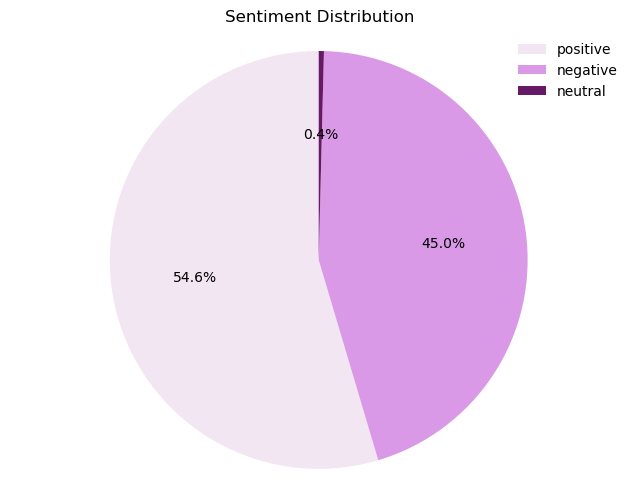

In [50]:
import matplotlib.pyplot as plt

# Define colors
light_purple = (0.95, 0.9, 0.95, 1)
dark_purple = (0.4, 0.1, 0.4, 1)
purple = (0.85, 0.6, 0.9, 1)

# Create pie chart
plt.figure(figsize=(8, 6))
patches, texts, autotexts = plt.pie(df_sentiment_counts['count'], colors=[light_purple, purple, dark_purple], autopct='%1.1f%%', startangle=90)

# Move the percentage values outside the pie chart
for autotext in autotexts:
    autotext.set_horizontalalignment('center')
    autotext.set_verticalalignment('center')

# Create a legend inside the pie chart
legend = plt.legend(patches, df_sentiment_counts['sentiment'], loc='upper right')  # Adjusting the legend position

# Hide the frame of the legend
legend.get_frame().set_visible(False)

# Find the index of the smallest slice
smallest_index = df_sentiment_counts['count'].idxmin()

# If the smallest slice is not the last one, move the legend outside
if smallest_index != len(df_sentiment_counts) - 1:
    # Move the legend outside the pie chart
    legend.set_bbox_to_anchor((1, 1))
    plt.subplots_adjust(left=0.1, right=0.7, top=0.9, bottom=0.1)

# Add title
plt.title('Sentiment Distribution')

# Ensure aspect ratio is equal to make it a circle
plt.axis('equal')

# Show plot
plt.show()


C:\Users\WMosleh\AppData\Local\Temp\ipykernel_26756\2881802309.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sentiment', y='count', data=df_sentiment_counts, palette='pastel')


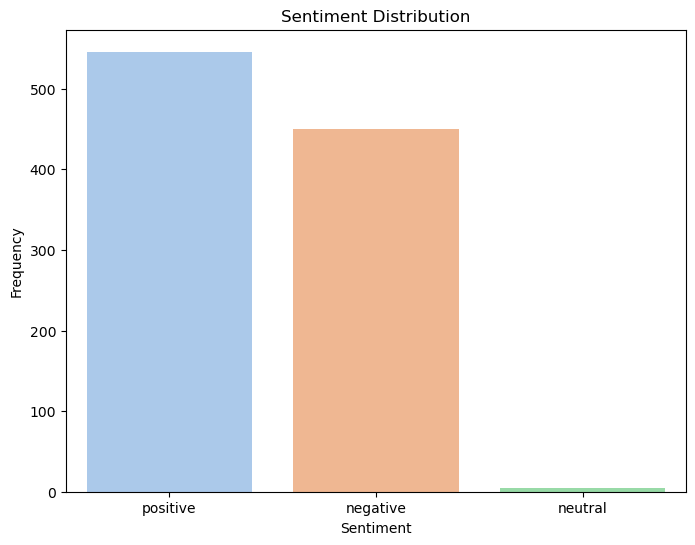

In [51]:
# 3. Bar Chart
plt.figure(figsize=(8, 6))
sns.barplot(x='sentiment', y='count', data=df_sentiment_counts, palette='pastel')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

C:\Users\WMosleh\AppData\Local\Temp\ipykernel_26756\3184688231.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment', y='sentiment_score', data=df, palette='pastel')


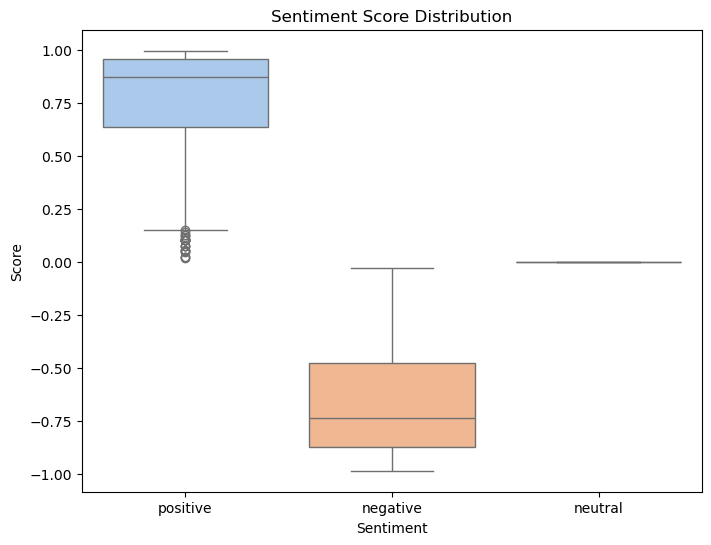

In [52]:
# 4. Box Plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='sentiment', y='sentiment_score', data=df, palette='pastel')
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Score')
plt.show()

In [53]:
from sklearn.decomposition import LatentDirichletAllocation

Topics and their top keywords:

    Topic 1  Topic 2   Topic 3
0    flight   flight      seat
1        ba     hour    flight
2       get    delay        ba
3  customer       ba      good
4   british   arrive     class
5      call    staff      food
6    airway  luggage      crew
7      book     time   service
8   service    check  business
9      tell    plane     cabin

Summary of topics:

Topic 1: flight, ba, get, customer, british, call, airway, book, service, tell
Topic 2: flight, hour, delay, ba, arrive, staff, luggage, time, check, plane
Topic 3: seat, flight, ba, good, class, food, crew, service, business, cabin


C:\Users\WMosleh\Anaconda3\lib\site-packages\wordcloud\wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
C:\Users\WMosleh\Anaconda3\lib\site-packages\wordcloud\wordcloud.py:523: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
C:\Users\WMosleh\Anaconda3\lib\site-packages\wordcloud\wordcloud.py:522: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
C:\Users\WMosleh\Anaconda3\lib\site-packages\wordcloud\wordcloud.py:522: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
C:\Users\WMosleh\Anaconda3\lib\site-pac

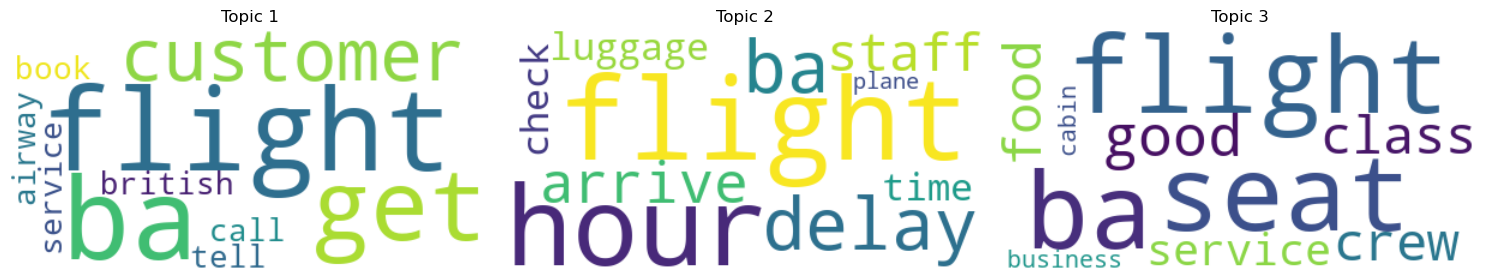

In [54]:
# Vectorize text data
text_data = df['processed_reviews'].apply(lambda tokens: ' '.join(tokens))

vectorizer = CountVectorizer(max_features=1000, max_df=0.9, min_df=10)
text_matrix = vectorizer.fit_transform(text_data)

# Fit LDA model
lda_model = LatentDirichletAllocation(n_components=3, random_state=42)
lda_model.fit(text_matrix)

# Extract topics and keywords
def get_topics(model, feature_names, num_words):
    word_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        word_dict["Topic %d" % (topic_idx+1)] = [feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]
    return pd.DataFrame(word_dict)

feature_names = vectorizer.get_feature_names_out()
num_words = 10
topics = get_topics(lda_model, feature_names, num_words)

print("Topics and their top keywords:\n")
print(topics)

# Summarize topics
summary = []
for i, topic in enumerate(lda_model.components_):
    top_keywords = ", ".join([feature_names[j] for j in topic.argsort()[:-num_words - 1:-1]])
    summary.append(f"Topic {i+1}: {top_keywords}")

print("\nSummary of topics:\n")
for line in summary:
    print(line)

# Visualize topics using WordCloud
fig, axes = plt.subplots(1, 3, figsize=(15, 3), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    wordcloud = WordCloud(stopwords=stopwords.words('english'), background_color='white').generate(" ".join(topics[f'Topic {i+1}']))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Topic {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()